<a href="https://colab.research.google.com/github/sabin5105/CIFAR10/blob/main/filter_activation/Cnn_hyperband_filter_activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner
from warnings import filterwarnings
filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 48.3 MB/s 


In [2]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import numpy as np
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
cifar=keras.datasets.cifar10
(X_train,y_train),(X_test,y_test)=cifar.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
X_train=X_train/255.0
X_test=X_test/255.0

In [5]:
n=len(np.unique(y_test))
n

10

In [6]:
y_train=to_categorical(y_train,n)
y_test=to_categorical(y_test,n)

In [7]:
from kerastuner import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

In [8]:
def build_model(hp):
    model=Sequential()

    #Buiding the convolutional layer
    model.add(Conv2D(filters=hp.Int('filter_1',min_value=16,max_value=256,step=16), kernel_size=3,activation='relu',input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=2))
    #adding the second layer
    model.add(Conv2D(filters=hp.Int('filter_2',min_value=16,max_value=256,step=16),kernel_size=3,activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=hp.Int('filter_2',min_value=16,max_value=256,step=16),kernel_size=3,activation='relu'))
    #Flattening the feature map
    model.add(Flatten())

    #Adding ANN layers 
    model.add(Dense(units=64,activation=hp.Choice(
                    "dense_activation",
                    values=["relu", "tanh", "sigmoid"],
                    default="relu",
                )))
   
    #adding the final layer
    model.add(Dense(units=10,activation='softmax'))

    #compiling the model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [13]:
tuner=Hyperband(build_model,
                   objective='val_accuracy',
                   max_epochs=3,
                  )

In [14]:
tuner.search(X_train,y_train,epochs=3,validation_split=0.2,verbose=2)

Trial 6 Complete [00h 04m 23s]
val_accuracy: 0.654699981212616

Best val_accuracy So Far: 0.6761000156402588
Total elapsed time: 00h 35m 17s


In [15]:
model=tuner.get_best_models(num_models=1)[0]

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 240)       207600    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 240)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 240)         518640    
                                                                 
 flatten (Flatten)           (None, 3840)              0

In [17]:
answer=model.fit(X_train,y_train,epochs=10,initial_epoch=3,validation_split=0.2)

Epoch 4/10
1250/1250 [==============================] - 336s 269ms/step - loss: 0.7700 - accuracy: 0.7324 - val_loss: 0.9097 - val_accuracy: 0.6870
Epoch 5/10
1250/1250 [==============================] - 335s 268ms/step - loss: 0.6635 - accuracy: 0.7664 - val_loss: 0.8169 - val_accuracy: 0.7200
Epoch 6/10
1250/1250 [==============================] - 336s 269ms/step - loss: 0.5707 - accuracy: 0.8006 - val_loss: 0.8896 - val_accuracy: 0.7059
Epoch 7/10
1250/1250 [==============================] - 334s 267ms/step - loss: 0.4782 - accuracy: 0.8330 - val_loss: 0.8704 - val_accuracy: 0.7216
Epoch 8/10
1250/1250 [==============================] - 336s 268ms/step - loss: 0.4039 - accuracy: 0.8601 - val_loss: 0.9102 - val_accuracy: 0.7188
Epoch 9/10
1250/1250 [==============================] - 346s 277ms/step - loss: 0.3356 - accuracy: 0.8837 - val_loss: 1.0566 - val_accuracy: 0.6912
Epoch 10/10
1250/1250 [==============================] - 342s 273ms/step - loss: 0.2670 - accuracy: 0.9084 - val

In [18]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 20s 64ms/step - loss: 1.0517 - accuracy: 0.7057


[1.0517195463180542, 0.7056999802589417]

In [19]:
pred = model.predict(X_test)

313/313 [==============================] - 20s 63ms/step


In [20]:
from sklearn.metrics import *
import numpy as np

pred = np.argmax(pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
print("Accuracy: ", accuracy_score(y_test, pred))
print("F1 Score: ", f1_score(y_test, pred, average='macro'))
print("Recall: ", recall_score(y_test, pred, average='macro'))
print("Precision: ", precision_score(y_test, pred, average='macro'))
print("-"*70)

Accuracy:  0.7057
F1 Score:  0.7039611065028231
Recall:  0.7057
Precision:  0.7096782916881121
----------------------------------------------------------------------


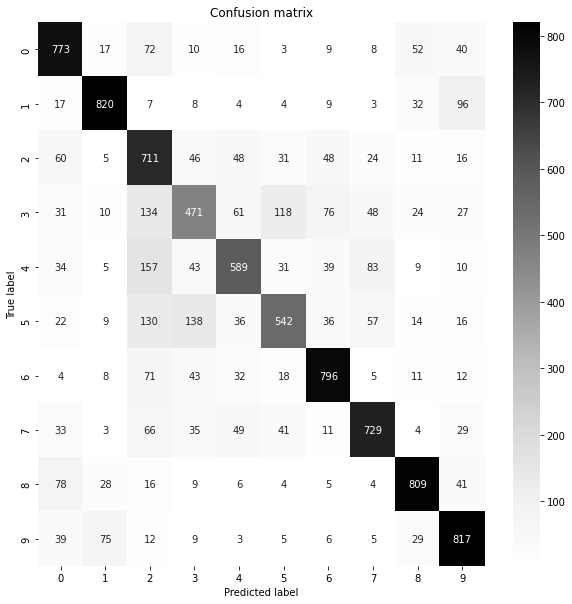

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greys')
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
from sklearn.metrics import classification_report
print("Classification Report: ", classification_report(y_test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.71      0.77      0.74      1000
           1       0.84      0.82      0.83      1000
           2       0.52      0.71      0.60      1000
           3       0.58      0.47      0.52      1000
           4       0.70      0.59      0.64      1000
           5       0.68      0.54      0.60      1000
           6       0.77      0.80      0.78      1000
           7       0.75      0.73      0.74      1000
           8       0.81      0.81      0.81      1000
           9       0.74      0.82      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000

